# ML2 Final Test

### Install Libraries

In [2]:
!pip install pandas numpy scikit-learn transformers torch lightgbm xgboost tensorflow  datasets seaborn matplotlib

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 25.0
[notice] To update, run: python -m pip install --upgrade pip


### Import libraies

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, ndcg_score, f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
from transformers import BertTokenizer, BertModel
import torch
import lightgbm as lgb
import xgboost as xgb
import tensorflow as tf
from sentence_transformers import SentenceTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout


2025-01-30 03:06:25.481546: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-30 03:06:25.641698: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-30 03:06:26.680619: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2025-01-30 03:06:26.680717

### Load Dataset

In [2]:
# Load the dataset
file_path = "/home/jovyan/ML2/train.csv"
data = pd.read_csv(file_path)

# Check for null values and drop them
data = data.dropna()

# Split into train, validation, and test sets
train_data, temp_data = train_test_split(data, test_size=0.3, random_state=45)
val_data, test_data = train_test_split(temp_data, test_size=2/3, random_state=45)

print(f"Train size: {len(train_data)}, Validation size: {len(val_data)}, Test size: {len(test_data)}")


Train size: 36821, Validation size: 5260, Test size: 10521


### Class imbalances 

In [3]:
# Balance training data using oversampling
train_majority = train_data[train_data["Priority"] == train_data["Priority"].value_counts().idxmax()]
train_minority = train_data[train_data["Priority"] != train_data["Priority"].value_counts().idxmax()]
balanced_train_data = pd.concat([
    train_majority,
    resample(train_minority, replace=True, n_samples=len(train_majority), random_state=42)
])
train_data = balanced_train_data.sample(frac=1, random_state=42).reset_index(drop=True)

In [4]:
print(f"Train size: {len(train_data)}, Validation size: {len(val_data)}, Test size: {len(test_data)}")

Train size: 43546, Validation size: 5260, Test size: 10521


### Data Preprocessing

In [5]:
# Encode target variable
label_encoder = LabelEncoder()
train_data['Priority'] = label_encoder.fit_transform(train_data['Priority'])
val_data['Priority'] = label_encoder.transform(val_data['Priority'])
test_data['Priority'] = label_encoder.transform(test_data['Priority'])

In [6]:
# Combine Title and Description into a single Text column
TEXT_COLUMNS = ['Title', 'Description']
train_data['Text'] = train_data[TEXT_COLUMNS].apply(lambda x: ' '.join(x), axis=1)
val_data['Text'] = val_data[TEXT_COLUMNS].apply(lambda x: ' '.join(x), axis=1)
test_data['Text'] = test_data[TEXT_COLUMNS].apply(lambda x: ' '.join(x), axis=1)

In [7]:
# One-hot encode categorical columns
CAT_COLUMNS = ['Component', 'Status', 'Resolution']

encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoder.fit(train_data[CAT_COLUMNS])

train_cat_encoded = encoder.transform(train_data[CAT_COLUMNS])
val_cat_encoded = encoder.transform(val_data[CAT_COLUMNS])
test_cat_encoded = encoder.transform(test_data[CAT_COLUMNS])

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### Text Embeddings with BERT

In [8]:
# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Generate embeddings for text data
def get_text_embeddings(texts, tokenizer, model, max_len=128):
    inputs = tokenizer(texts, padding=True, truncation=True, max_length=max_len, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).numpy()


In [13]:
train_text_embeddings = get_text_embeddings(train_data['Text'].tolist(), tokenizer, model)
val_text_embeddings = get_text_embeddings(val_data['Text'].tolist(), tokenizer, model)
test_text_embeddings = get_text_embeddings(test_data['Text'].tolist(), tokenizer, model)

In [17]:
# Save as NumPy arrays
np.save('train_text_embeddings.npy', train_text_embeddings)
np.save('val_text_embeddings.npy', val_text_embeddings)
np.save('test_text_embeddings.npy', test_text_embeddings)


In [9]:
# Load the saved embeddings
train_text_embeddings = np.load('train_text_embeddings.npy')
val_text_embeddings = np.load('val_text_embeddings.npy')
test_text_embeddings = np.load('test_text_embeddings.npy')

### Trying TF-IDF here

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

#  TF-IDF Feature Extraction
tfidf = TfidfVectorizer(max_features=100)  # Extract 100 useful word features
train_tfidf_features = tfidf.fit_transform(train_data['Text']).toarray()
val_tfidf_features = tfidf.transform(val_data['Text']).toarray()
test_tfidf_features = tfidf.transform(test_data['Text']).toarray()


### Combine Features

In [41]:
# Checking if the array sizes are same
print(f"train_text_embeddings shape: {train_text_embeddings.shape}")
print(f"train_cat_encoded shape: {train_cat_encoded.shape}")
print(f"val_text_embeddings shape: {val_text_embeddings.shape}")
print(f"val_cat_encoded shape: {val_cat_encoded.shape}")
print(f"test_text_embeddings shape: {test_text_embeddings.shape}")
print(f"test_cat_encoded shape: {test_cat_encoded.shape}")

train_text_embeddings shape: (43546, 768)
train_cat_encoded shape: (43546, 182)
val_text_embeddings shape: (5260, 768)
val_cat_encoded shape: (5260, 182)
test_text_embeddings shape: (10521, 768)
test_cat_encoded shape: (10521, 182)


In [42]:
# Merge All Features
X_train = np.hstack([train_text_embeddings, train_tfidf_features, train_cat_encoded])
X_val = np.hstack([val_text_embeddings, val_tfidf_features, val_cat_encoded])
X_test = np.hstack([test_text_embeddings, test_tfidf_features, test_cat_encoded])

# Print shape of features for confirmation
print("Final Feature Shapes:", X_train.shape, X_val.shape, X_test.shape)

y_train = train_data['Priority']
y_val = val_data['Priority']
y_test = test_data['Priority']

Final Feature Shapes: (43546, 1050) (5260, 1050) (10521, 1050)


## Train Gradient Boosting Models

### Train XGB Model

In [43]:
# Train XGBoost
xgb_model = xgb.XGBClassifier(eval_metric='mlogloss', use_label_encoder=False)
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10)

# Evaluate XGBoost
xgb_val_predictions = xgb_model.predict(X_val)
xgb_test_predictions = xgb_model.predict(X_test)

/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:1.39358
[1]	validation_0-mlogloss:1.27417
[2]	validation_0-mlogloss:1.19816
[3]	validation_0-mlogloss:1.14791
[4]	validation_0-mlogloss:1.11006
[5]	validation_0-mlogloss:1.08384
[6]	validation_0-mlogloss:1.06418
[7]	validation_0-mlogloss:1.04952
[8]	validation_0-mlogloss:1.03866
[9]	validation_0-mlogloss:1.03068
[10]	validation_0-mlogloss:1.02483
[11]	validation_0-mlogloss:1.01958
[12]	validation_0-mlogloss:1.01591
[13]	validation_0-mlogloss:1.01315
[14]	validation_0-mlogloss:1.01104
[15]	validation_0-mlogloss:1.00905
[16]	validation_0-mlogloss:1.00659
[17]	validation_0-mlogloss:1.00556
[18]	validation_0-mlogloss:1.00613
[19]	validation_0-mlogloss:1.00521
[20]	validation_0-mlogloss:1.00526
[21]	validation_0-mlogloss:1.00417
[22]	validation_0-mlogloss:1.00364
[23]	validation_0-mlogloss:1.00305
[24]	validation_0-mlogloss:1.00250
[25]	validation_0-mlogloss:1.00149
[26]	validation_0-mlogloss:1.00148
[27]	validation_0-mlogloss:1.00117
[28]	validation_0-mlogloss:1.0

In [44]:
print("XGBoost Validation Report:")
print(classification_report(y_val, xgb_val_predictions))
print("XGBoost Test Report:")
print(classification_report(y_test, xgb_test_predictions))

XGBoost Validation Report:
              precision    recall  f1-score   support

           0       0.45      0.35      0.39       914
           1       0.35      0.22      0.27       954
           2       0.69      0.89      0.77      3017
           3       0.52      0.06      0.11       246
           4       0.43      0.08      0.13       129

    accuracy                           0.61      5260
   macro avg       0.49      0.32      0.33      5260
weighted avg       0.57      0.61      0.57      5260

XGBoost Test Report:
              precision    recall  f1-score   support

           0       0.45      0.38      0.41      1741
           1       0.37      0.21      0.27      1943
           2       0.70      0.90      0.79      6125
           3       0.56      0.05      0.10       473
           4       0.61      0.15      0.25       239

    accuracy                           0.63     10521
   macro avg       0.54      0.34      0.36     10521
weighted avg       0.59      

### Train LGBM Model

In [45]:
# Train LightGBM
lgbm_model = lgb.LGBMClassifier()
lgbm_model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

# Evaluate LightGBM
lgbm_val_predictions = lgbm_model.predict(X_val)
lgbm_test_predictions = lgbm_model.predict(X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.117766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 221569
[LightGBM] [Info] Number of data points in the train set: 43546, number of used features: 983
[LightGBM] [Info] Start training from score -1.582388
[LightGBM] [Info] Start training from score -1.533747
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] Start training from score -2.951398
[LightGBM] [Info] Start training from score -3.629718


In [46]:
print("LGBMBoost Validation Report:")
print(classification_report(y_val, lgbm_val_predictions))
print("LGBMBoost Test Report:")
print(classification_report(y_test, lgbm_test_predictions))

LGBMBoost Validation Report:
              precision    recall  f1-score   support

           0       0.46      0.36      0.40       914
           1       0.35      0.21      0.27       954
           2       0.69      0.90      0.78      3017
           3       0.50      0.07      0.12       246
           4       0.50      0.10      0.17       129

    accuracy                           0.62      5260
   macro avg       0.50      0.33      0.35      5260
weighted avg       0.58      0.62      0.58      5260

LGBMBoost Test Report:
              precision    recall  f1-score   support

           0       0.45      0.38      0.41      1741
           1       0.37      0.20      0.26      1943
           2       0.70      0.90      0.79      6125
           3       0.57      0.06      0.10       473
           4       0.57      0.16      0.25       239

    accuracy                           0.63     10521
   macro avg       0.53      0.34      0.36     10521
weighted avg       0.59  

## Train LambdaMART

In [51]:
# Prepare LightGBM datasets
train_group = [len(y_train)]  # Single group for the dataset
val_group = [len(y_val)]

train_lgb = lgb.Dataset(X_train, label=y_train, group=train_group)
val_lgb = lgb.Dataset(X_val, label=y_val, group=val_group, reference=train_lgb)


In [52]:
# Simulate smaller group sizes (e.g., each group contains 500 samples)
group_size = 500
train_group = [group_size] * (len(y_train) // group_size)
val_group = [group_size] * (len(y_val) // group_size)

# Add remainder to the last group, if any
if len(y_train) % group_size > 0:
    train_group.append(len(y_train) % group_size)
if len(y_val) % group_size > 0:
    val_group.append(len(y_val) % group_size)

# Update LightGBM dataset
train_lgb = lgb.Dataset(X_train, label=y_train, group=train_group)
val_lgb = lgb.Dataset(X_val, label=y_val, group=val_group, reference=train_lgb)

In [53]:
# LambdaMART parameters

params = {
    "objective": "lambdarank",
    "metric": "ndcg",
    "learning_rate": 0.05,  # Lower learning rate for better generalization
    "num_leaves": 64,       # Balanced complexity
    "min_data_in_leaf": 20,  # Prevents overfitting
    "lambdarank_truncation_level": 10,
    "early_stopping_round": 10  # Use this parameter for early stopping
}

# Train LambdaMART model
lgb_model = lgb.train(params, train_lgb, valid_sets=[train_lgb, val_lgb])


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 221569
[LightGBM] [Info] Number of data points in the train set: 43546, number of used features: 983
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[8]	training's ndcg@1: 0.927273	training's ndcg@2: 0.86397	training's ndcg@3: 0.825215	training's ndcg@4: 0.792586	training's ndcg@5: 0.769078	valid_1's ndcg@1: 0.636364	valid_1's ndcg@2: 0.551959	valid_1's ndcg@3: 0.573186	valid_1's ndcg@4: 0.511527	valid_1's ndcg@5: 0.502312


In [54]:
# Predict rankings
lgb_val_preds = lgb_model.predict(X_val)
lgb_test_preds = lgb_model.predict(X_test)

### Compute NDCG & MRR Scores

In [77]:
from sklearn.metrics import ndcg_score
from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer

def mean_reciprocal_rank(y_true, y_pred):
    ranks = np.argsort(np.argsort(-y_pred)) + 1  # Rank from highest to lowest
    correct_rank_indices = np.where(y_true == max(y_true))  # Only consider highest priority P4
    mrr_values = 1 / ranks[correct_rank_indices]
    return np.mean(mrr_values) if len(mrr_values) > 0 else 0

# Compute NDCG and MRR before label conversion
ndcg_mrr_results = []
for model_name, (y_true, y_pred) in {
    "XGBoost": (y_test, xgb_test_predictions),
    "LightGBM": (y_test, lgbm_test_predictions),
    "LambdaMART": (y_test, lgb_test_preds),
}.items():
    ndcg = ndcg_score([y_true], [y_pred])
    mrr = mean_reciprocal_rank(np.array(y_true), np.array(y_pred))
    ndcg_mrr_results.append([model_name, ndcg, mrr])

ndcg_mrr_df = pd.DataFrame(ndcg_mrr_results, columns=["Model", "NDCG", "MRR"])
print("NDCG & MRR Before Label Conversion:\n", ndcg_mrr_df)

# Normalize scores between 0-1
scaler = MinMaxScaler()
lgb_test_preds_scaled = scaler.fit_transform(lgb_test_preds.reshape(-1, 1)).flatten()

# Convert scores to class labels using binning
num_classes = len(np.unique(y_test))
binarizer = KBinsDiscretizer(n_bins=num_classes, encode='ordinal', strategy='quantile')
lambdamart_labels = binarizer.fit_transform(lgb_test_preds_scaled.reshape(-1, 1)).astype(int)

# Convert predicted scores into discrete labels
xgb_test_labels = xgb_test_predictions.astype(int)  # XGBoost
lgb_test_labels = lgbm_test_predictions.astype(int)  # LightGBM

# Compute classification metrics after conversion
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

results = []
models = {
    "XGBoost": (y_test, xgb_test_labels),
    "LightGBM": (y_test, lgb_test_labels),
    "LambdaMART": (y_test, lambdamart_labels),
}

i = 0
for model_name, (y_true, y_pred) in models.items():
    
    f1 = f1_score(y_true, y_pred, average="weighted")
    precision = precision_score(y_true, y_pred, average="weighted")
    recall = recall_score(y_true, y_pred, average="weighted")
    accuracy = accuracy_score(y_true, y_pred)
    i = i + 1

    results.append([model_name, f1, precision, recall, accuracy])
    
    if i == 2:
        break


results_df = pd.DataFrame(results, columns=["Model", "F1 Score", "Precision", "Recall", "Accuracy"])
print("\nFinal Evaluation Results:\n", results_df)


NDCG & MRR Before Label Conversion:
         Model      NDCG       MRR
0     XGBoost  0.953202  0.010902
1    LightGBM  0.953753  0.012134
2  LambdaMART  0.955244  0.014122

Final Evaluation Results:
       Model  F1 Score  Precision    Recall  Accuracy
0   XGBoost  0.585871   0.589734  0.630739  0.630739
1  LightGBM  0.586815   0.590320  0.632544  0.632544


### Generate Confusion Matrices

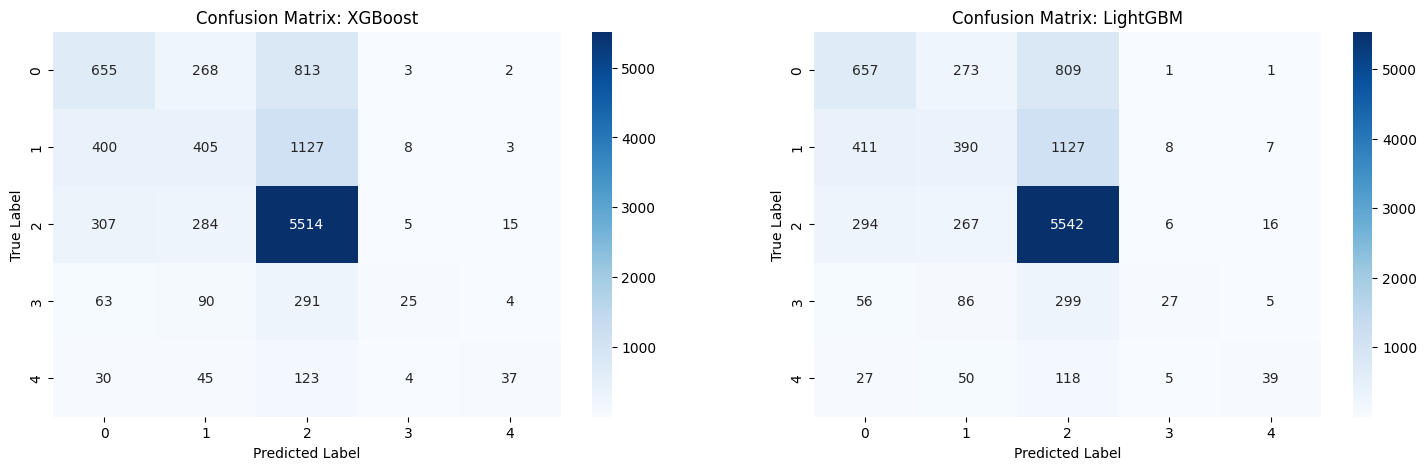

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(1, 2, figsize=(18, 5))

i = 0
for ax, (model_name, (y_true, y_pred)) in zip(axes, models.items()):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(f"Confusion Matrix: {model_name}")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    i = i+1
    
    if i == 2:
        break

plt.show()